In [4]:
import boto3
import pandas as pd

query = boto3.client('timestream-query', region_name='us-east-1')

QUERY_STRING = """
SELECT time, measure_value::bigint AS bytes
FROM "netvizion_db"."netvizion_table"
WHERE measure_name = 'bytes_transferred'
ORDER BY time ASC
LIMIT 1000
"""

response = query.query(QueryString=QUERY_STRING)

# Convert response to DataFrame
rows = response['Rows']
columns = [col['Name'] for col in response['ColumnInfo']]
records = []

for row in rows:
    values = [col.get('ScalarValue') for col in row['Data']]
    records.append(dict(zip(columns, values)))

df = pd.DataFrame(records)
df['time'] = pd.to_datetime(df['time'])
df['bytes'] = pd.to_numeric(df['bytes'])
df = df[['time', 'bytes']].rename(columns={"time": "ds", "bytes": "y"})
df.head()


,ds,y
0,2025-06-12 20:20:18.822,5397
1,2025-06-12 20:20:19.795,2563
2,2025-06-12 20:20:22.800,9543
3,2025-06-12 20:20:25.818,5383
4,2025-06-12 20:20:26.794,9358


18:11:37 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing


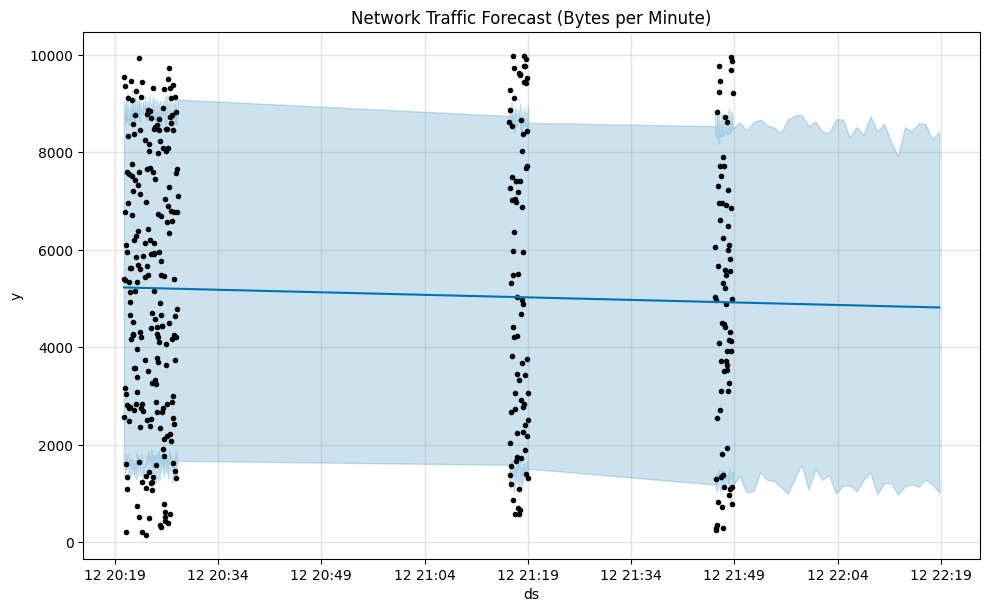

In [5]:
from prophet import Prophet
import matplotlib.pyplot as plt

model = Prophet()
model.fit(df)

# Forecast 30 minutes into the future (or more)
future = model.make_future_dataframe(periods=30, freq='min')  # adjust as needed
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Network Traffic Forecast (Bytes per Minute)")
plt.show()


In [9]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("forecast_results.csv", index=False)


In [6]:
%pip install --quiet "nbformat>=4.2.0"

import plotly.graph_objects as go

# 'df' is already defined in previous cells, so no need to check for its existence.

# Actual vs Predicted Interactive Plot
fig = go.Figure()

# Actual traffic (from training data)
fig.add_trace(go.Scatter(
    x=df['ds'],
    y=df['y'],
    mode='lines+markers',
    name='Actual Traffic'
))

# Forecasted traffic
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    name='Forecasted Traffic',
    line=dict(color='orange')
))

# Confidence interval
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    mode='lines',
    name='Upper Bound',
    line=dict(width=0),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    mode='lines',
    name='Lower Bound',
    line=dict(width=0),
    fill='tonexty',
    fillcolor='rgba(255, 165, 0, 0.2)',
    showlegend=True
))

# Layout settings
fig.update_layout(
    title="Interactive Forecast: Network Traffic (Bytes per Minute)",
    xaxis_title="Time",
    yaxis_title="Bytes",
    legend=dict(x=0, y=1),
    template="plotly_white"
)

fig.show()



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: d:\AWS_NetVizion\forcast\.venv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
